# Calibration of non-isoplanatic low frequency data

This uses a variant the SageCAL algorithm to calibrate a simulated SKA1LOW observation in which sources inside the primary beam have one set of calibration errors and sources outside have different errors.

In this example, the peeler sources are held fixed in strength and location and only the gains solved. The other source, inside the primary beam are both allowed to vary in strength and location and an overall gain is solvd.


In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.skycomponent.operations import find_skycomponents, find_nearest_skycomponent
from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable, create_gaintable_from_blockvisibility
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility, copy_visibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import restore_cube
from arl.skycomponent.operations import insert_skycomponent, select_components_by_separation
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.visibility.iterators import vis_timeslice_iter
from arl.visibility.coalesce import convert_visibility_to_blockvisibility
from arl.util.testing_support import create_named_configuration, create_low_test_beam, \
    simulate_gaintable, create_low_test_skycomponents_from_gleam
from arl.skycomponent.operations import apply_beam_to_skycomponent, copy_skycomponent, find_skycomponent_matches
from arl.imaging import create_image_from_visibility, advise_wide_field, predict_skycomponent_visibility
from arl.imaging.imaging_context import invert_function, predict_function

from arl.calibration.skymodel_cal import skymodel_cal_solve, create_cal_skymodel
from arl.calibration.skymodel_cal_delayed import create_skymodel_cal_solve_graph

from arl.graphs.dask_init import get_dask_Client
from arl.image.operations import export_image_to_fits

import logging

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

We make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

We set the w coordinate to be zero for all visibilities so as not to have to do full w-term processing. This speeds up the imaging steps.

In [2]:
nfreqwin = 1
ntimes = 1
rmax = 750
frequency = numpy.linspace(0.8e8, 1.2e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.4e8]
times = numpy.linspace(-numpy.pi / 3.0, numpy.pi / 3.0, ntimes)

phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency,
    channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"), zerow=True)

create_blockvisibility: 1 rows, 0.002 GB


In [3]:
wprojection_planes=1
advice=advise_wide_field(block_vis, guard_band_image=5.0, delA=0.02, 
                         wprojection_planes=wprojection_planes)

vis_slices = advice['vis_slices']
npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 3.747 (meters)
advise_wide_field: Maximum baseline 325.8 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.535344 (rad) 30.673 (deg)
advise_wide_field: Synthesized beam 0.003069 (rad) 0.176 (deg)
advise_wide_field: Cellsize 0.001023 (rad) 0.059 (deg)
advice_wide_field: Npixels per side = 523
advice_wide_field: Npixels (power of 2, 3) per side = 768
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 18.7 (s)
advice_wide_field: Time sampling for primary beam = 468.7 (s)
advice_wide_field: Frequency sampling for full image = 17360.7 (Hz)
advice_wide_field: Frequency sampling for primary beam = 434018.6 (Hz)
advice_wide_field: Number of planes in w sta

Generate the model from the GLEAM catalog, including application of the primary beam.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (30., -45.)>, starting frequency 80000000.0 Hz, and bandwidth 39999999.9996 Hz
create_image_from_visibility: uvmax = 184.628265 wavelengths
create_image_from_visibility: Critical cellsize = 0.002708 radians, 0.155165 degrees
create_image_from_visibility: Cellsize          = 0.001023 radians, 0.058616 degrees
create_low_test_skycomponents_from_gleam: 507 sources above flux limit 1.000
create_low_test_beam: primary beam is defined at 100.000 MHz
Number of components 53


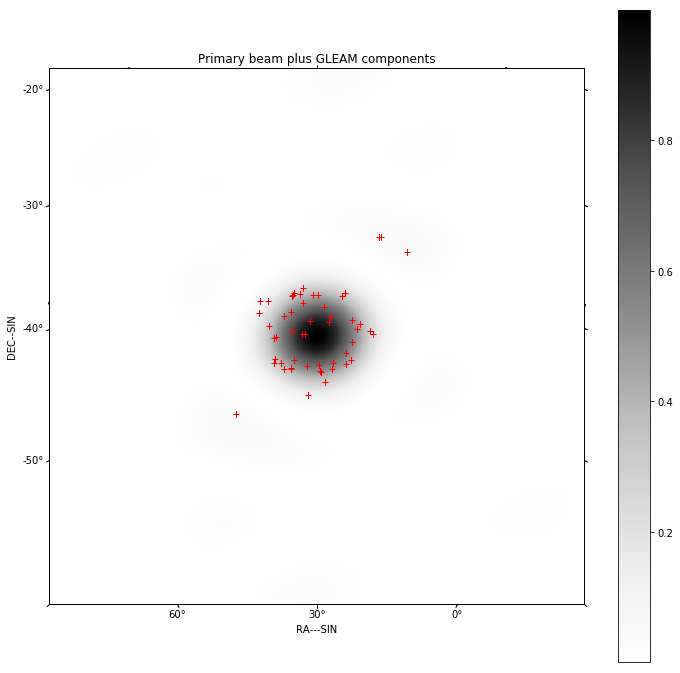

In [4]:
beam = create_image_from_visibility(block_vis, npixel=npixel, frequency=frequency,
    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

original_gleam_components = create_low_test_skycomponents_from_gleam(flux_limit=1.0,
    phasecentre=phasecentre, frequency=frequency, 
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=npixel * cellsize/2.0)

beam = create_low_test_beam(beam)
pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components, beam, 
                                                       flux_limit=0.5)
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'


show_image(beam, components=pb_gleam_components, cm='Greys', title='Primary beam plus GLEAM components')
print("Number of components %d" % len(pb_gleam_components))

Generate the template image

In [5]:
model = create_image_from_visibility(block_vis, npixel=npixel, 
                                     frequency=[numpy.average(frequency)], 
                                     nchan=1,
                                     channel_bandwidth=[numpy.sum(channel_bandwidth)], 
                                     cellsize=cellsize, phasecentre=phasecentre)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (30., -45.)>, starting frequency 80000000.0 Hz, and bandwidth [40000000.] Hz
create_image_from_visibility: uvmax = 184.628265 wavelengths
create_image_from_visibility: Critical cellsize = 0.002708 radians, 0.155165 degrees
create_image_from_visibility: Cellsize          = 0.001023 radians, 0.058616 degrees


Create sources to be peeled

In [6]:
peel_distance = 0.16
peelers = select_components_by_separation(phasecentre, pb_gleam_components, 
                                          min=peel_distance)
gleam_components = select_components_by_separation(phasecentre, pb_gleam_components, 
                                          max=peel_distance)
print("There are %d sources inside the primary beam and %d sources outside"
     % (len(gleam_components), len(peelers)))

There are 49 sources inside the primary beam and 4 sources outside


Create the model visibilities, applying a different gain table for peeled sources and other components

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '9.817878543395862'
		min: '-0.32819930551002574'
		rms: '0.1248317415433757'
		sum: '-79.82307376716274'
		medianabs: '0.05920163089668669'
		median: '-0.009916793001628038'



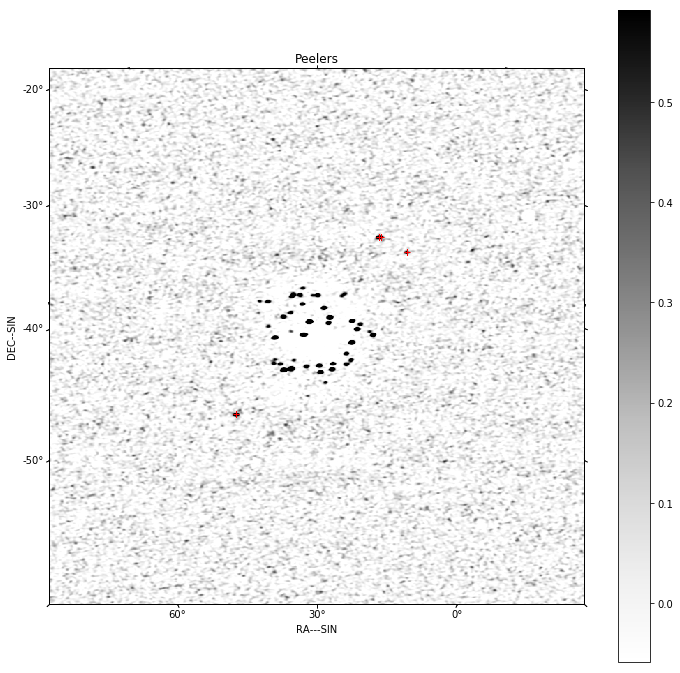

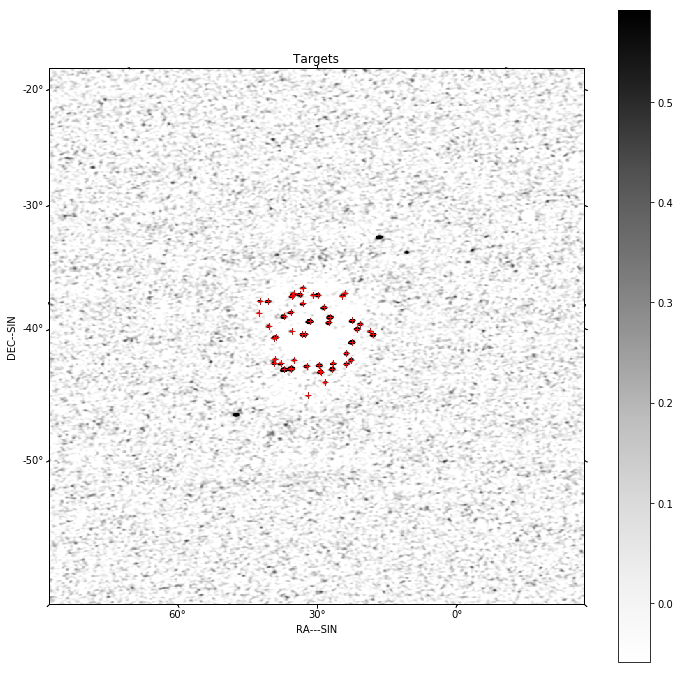

In [7]:
corrupted_vis = copy_visibility(block_vis, zero=True)
gt = create_gaintable_from_blockvisibility(block_vis, timeslice='auto')

components_errors = [(p, 1.0) for p in peelers]
components_errors.append((pb_gleam_components, 0.1))

for sc, phase_error in components_errors:
    component_vis = copy_visibility(block_vis, zero=True)
    gt = simulate_gaintable(gt, amplitude_error=0.0, phase_error=phase_error)
    component_vis = predict_skycomponent_visibility(component_vis, sc)
    component_vis = apply_gaintable(component_vis, gt)
    corrupted_vis.data['vis'][...]+=component_vis.data['vis'][...]
    
dirty, sumwt = invert_function(corrupted_vis, model, context='2d')
qa=qa_image(dirty)
vmax=qa.data['medianabs']*10.0
vmin=-qa.data['medianabs']
print(qa)
export_image_to_fits(dirty, '%s/skymodel_cal_before_dirty.fits' % results_dir)
show_image(dirty, cm='Greys', components=peelers, vmax=vmax, vmin=vmin, title='Peelers')
show_image(dirty, cm='Greys', components=gleam_components, vmax=vmax, vmin=vmin, title='Targets')
plt.show()

Find the components above the threshold

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '9.817878543395862'
		min: '-0.32819930551002574'
		rms: '0.1248317415433757'
		sum: '-79.82307376716274'
		medianabs: '0.05920163089668669'
		median: '-0.009916793001628038'

Selecting sources brighter than 0.592016
find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 38 segments


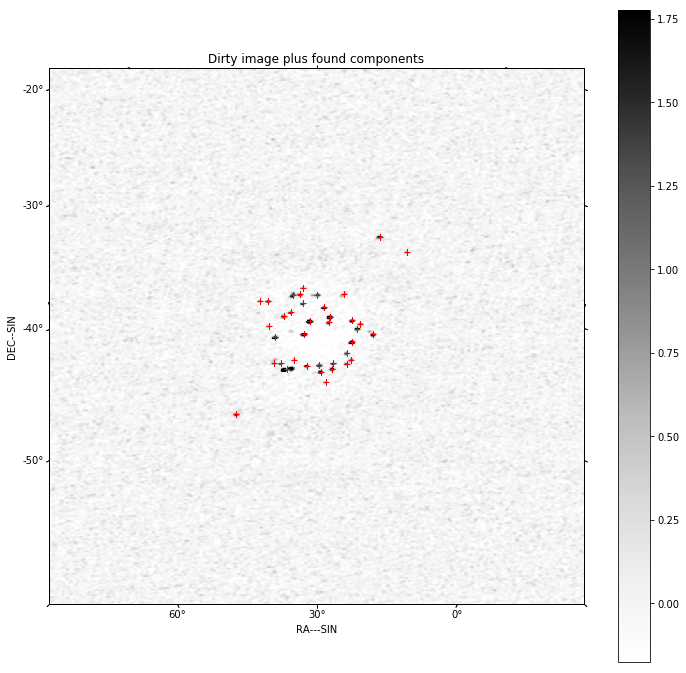

In [8]:
qa = qa_image(dirty)
vmax=qa.data['medianabs']*30.0
vmin=-qa.data['medianabs']*3.0
print(qa)
threshold = 10.0*qa.data['medianabs']
print("Selecting sources brighter than %f" % threshold)
found_components= find_skycomponents(dirty, threshold=threshold)
show_image(dirty, components=found_components, cm='Greys', vmax=vmax, vmin=vmin,
           title='Dirty image plus found components')
plt.show()

Partition the found sources into peeler sources and target sources. Then set up the graph to create the skymodels. We 
fix the peeled sources so that only the gaintable is solved.

In [9]:
peel_distance = 0.16
peelers = select_components_by_separation(phasecentre, found_components, 
                                          min=peel_distance)
gleam_components = select_components_by_separation(phasecentre, found_components, 
                                          max=peel_distance)
from arl.data.skymodel import SkyModel

from dask import delayed
                  
calskymodel_graph = [delayed(SkyModel, nout=1)(components=[p], fixed=True) for p in peelers]
calskymodel_graph.append(delayed(SkyModel, nout=1)(components=found_components))

Run skymodel_cal using dask

In [10]:
client = get_dask_Client()
corrupted_vis = client.scatter(corrupted_vis)
graph = create_skymodel_cal_solve_graph(corrupted_vis, calskymodel_graph, niter=30, 
                                        gain=0.25, tol=1e-8)
calskymodel, residual_vis = client.compute(graph, sync=True)
client.close()

Creating LocalCluster and Dask Client
<Client: scheduler='tcp://127.0.0.1:55880' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:8787


Combine all components for display

In [11]:
final_components = list()
for csm in calskymodel:
    for comp in csm[0].components:
        final_components.append(comp)

Check that the peeled sources are not altered

In [12]:
recovered_peelers = find_skycomponent_matches(peelers, final_components, 1e-5)
ok = True
for p in recovered_peelers:
    ok = ok and numpy.abs(peelers[p[0]].flux[0,0] - final_components[p[1]].flux[0,0]) < 1e-7
print("Peeler sources flux unchanged: %s" % ok)
ok = True
for p in recovered_peelers:
    ok = ok and peelers[p[0]].direction.separation(final_components[p[1]].direction).rad < 1e-15
print("Peeler sources directions unchanged: %s" % ok)

Peeler sources flux unchanged: True
Peeler sources directions unchanged: True


Now we find the components in the residual image and add those to the existing model

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 768, 768)'
		max: '2.6993782268235247'
		min: '-0.21628429472750088'
		rms: '0.028001488292756612'
		sum: '-0.6291635216470319'
		medianabs: '0.013487430863849004'
		median: '-0.002632920787206804'

Selecting sources brighter than 0.269749
find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 14 segments


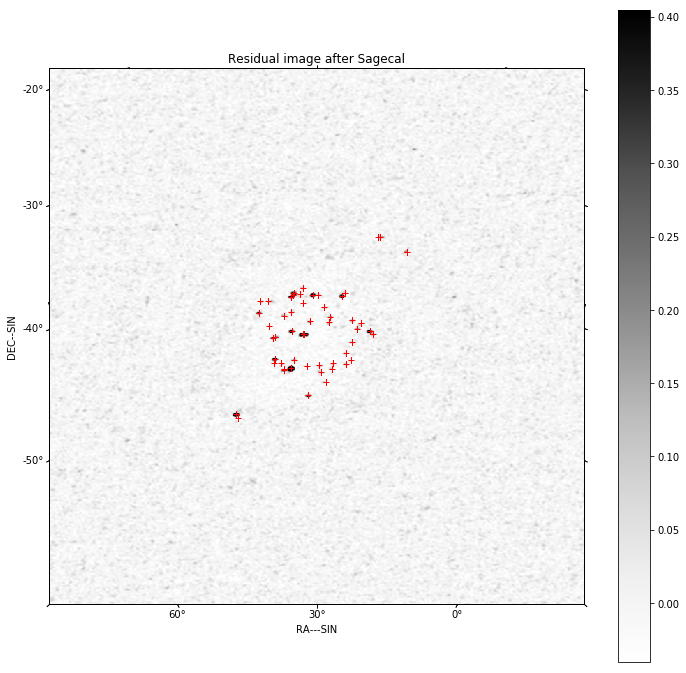

In [13]:
residual, sumwt = invert_function(residual_vis, model, context='2d')
qa = qa_image(residual)
vmax=qa.data['medianabs']*30.0
vmin=-qa.data['medianabs']*3.0
print(qa)
threshold = 20.0*qa.data['medianabs']
print("Selecting sources brighter than %f" % threshold)

found_components= find_skycomponents(residual, threshold=threshold)
for sc in found_components:
    final_components.append(sc)

show_image(residual, components=final_components, cm='Greys', 
           title='Residual image after Sagecal', vmax=vmax, vmin=vmin)
plt.show()

Make a restored image

Quality assessment:
	Origin: qa_image
	Context: Restored image after SageCal
	Data:
		shape: '(1, 1, 768, 768)'
		max: '10.142626455235531'
		min: '-0.06668982198552044'
		rms: '0.12033868531088462'
		sum: '3914.078442397197'
		medianabs: '0.013557219564540209'
		median: '-0.0023529199682726138'



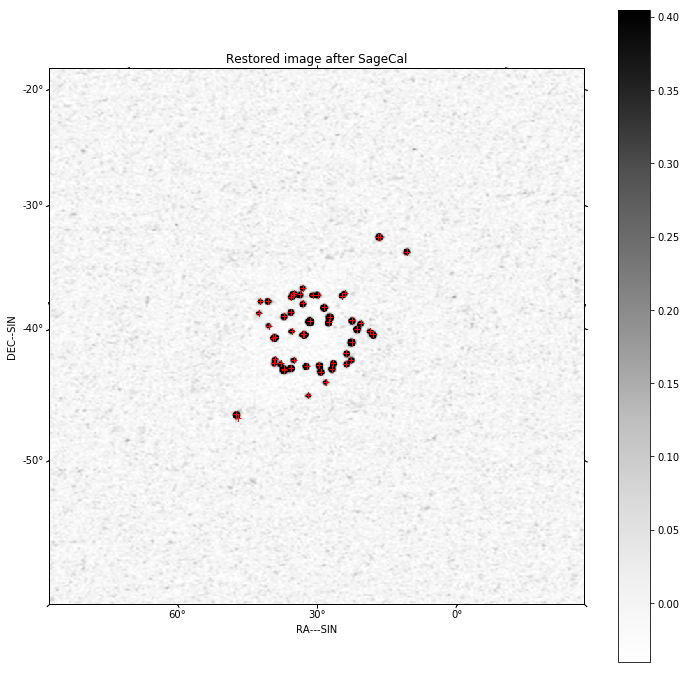

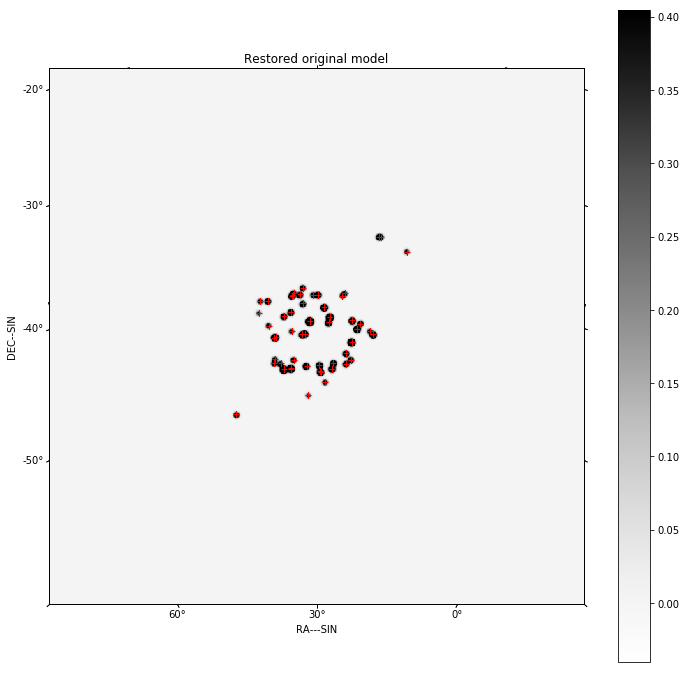

In [14]:
psf, _ = invert_function(residual_vis, model, dopsf=True, context='2d')

component_image = copy_image(model)
component_image.data[...] = 0.0
component_image= insert_skycomponent(component_image, final_components)
restored = restore_cube(component_image, psf, residual)
export_image_to_fits(restored, '%s/skymodel_cal_after_noniso_dirty.fits' % results_dir)

qa=qa_image(restored, context='Restored image after SageCal')
print(qa)


show_image(restored, components=final_components, cm='Greys', 
           title='Restored image after SageCal', vmax=vmax, vmin=vmin)
plt.show()

residual.data[...] = 0.0
component_image = copy_image(model)
component_image.data[...] = 0.0
component_image= insert_skycomponent(component_image, pb_gleam_components)
restored = restore_cube(component_image, psf, residual)
export_image_to_fits(restored, '%s/skymodel_cal_restored_model.fits' % results_dir)

show_image(restored, components=pb_gleam_components, cm='Greys', 
           title='Restored original model', vmax=vmax, vmin=vmin)
plt.show()


Now match the recovered compoenents to the originals

In [15]:
matches = find_skycomponent_matches(final_components, pb_gleam_components, 3*cellsize)

Look at the range of separations found

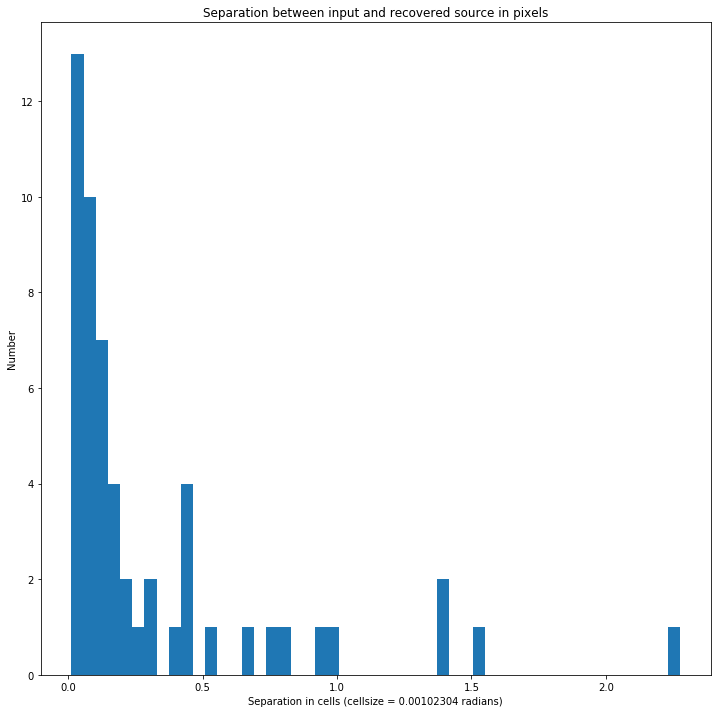

In [16]:
separations = [match[2] for match in matches]
plt.clf()
plt.hist(separations/cellsize, bins=50)
plt.title('Separation between input and recovered source in pixels')
plt.xlabel('Separation in cells (cellsize = %g radians)' % cellsize)
plt.ylabel('Number')
plt.show()

Now look at the matches between the original components and those recovered.

In [17]:
totalfluxin = numpy.sum([c.flux[0,0] for c in pb_gleam_components])
totalfluxout = numpy.sum([c.flux[0,0] for c in final_components]) 
print("Recovered %.3f (Jy) of original %.3f (Jy)" % (totalfluxout, totalfluxin))
found = [match[1] for match in matches]
notfound = list()
for c in range(len(pb_gleam_components)):
    if c not in found:
        notfound.append(c)
        
print("The following original components were not found", notfound)

Recovered 106.230 (Jy) of original 109.996 (Jy)
The following original components were not found [6, 13, 52]


Look at the recovered flux and the location of the unmatched components. From the image display these seem to be blends of close components.

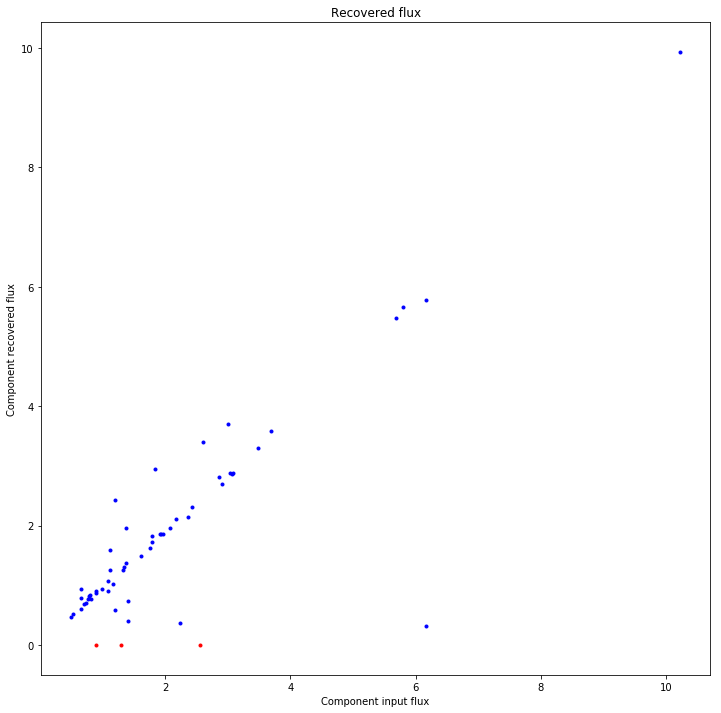

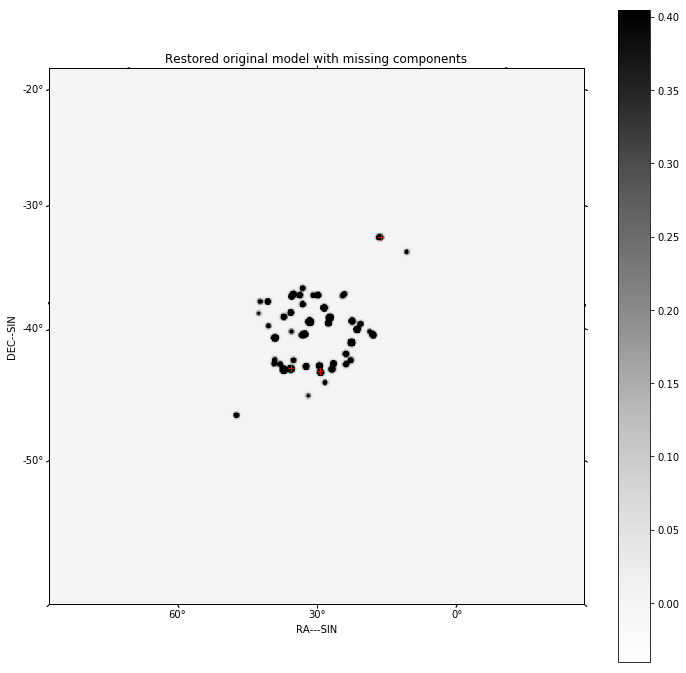

Recovered 106.230 (Jy) of original 110 (Jy) flux


In [18]:
fluxin = [pb_gleam_components[match[1]].flux[0,0] for match in matches]
fluxout = [final_components[match[0]].flux[0,0] for match in matches]
missed_components = [pb_gleam_components[c] for c in notfound]
missed_flux = [match.flux[0,0] for match in missed_components]
    
plt.clf()
plt.plot(fluxin, fluxout, '.', color='blue')
plt.plot(missed_flux, len(missed_flux)*[0.0], '.', color='red')

plt.title('Recovered flux')
plt.xlabel('Component input flux')
plt.ylabel('Component recovered flux')
plt.show()

show_image(restored, components=missed_components, cm='Greys', 
           title='Restored original model with missing components', vmax=vmax, vmin=vmin)
plt.show()
    
print("Recovered %.3f (Jy) of original %3.f (Jy) flux" % (totalfluxout, totalfluxin))